In [41]:
import os
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
# to see the whole dataframe
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv(r"C:\Users\Cyrus\Documents\Data Projects\bbc nlp\data\entertainment\entertainment.csv")
# view first 10 rows
df.head(10)

,Category,Text,Filename,Subcategory
0,entertainment,"Gallery unveils interactive tree\n\nA Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.\n\nThe spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be ""unwrapped"" by sculptor Richard Wentworth, who is responsible for decorating the tree with broken plates and light bulbs. It is the 17th year that the gallery has invited an artist to dress their Christmas tree. Artists who have decorated the Tate tree in previous years include Tracey Emin in 2002.\n\nThe plain green Norway spruce is displayed in the gallery's foyer. Its light bulb adornments are dimmed, ordinary domestic ones joined together with string. The plates decorating the branches will be auctioned off for the children's charity ArtWorks. Wentworth worked as an assistant to sculptor Henry Moore in the late 1960s. His reputation as a sculptor grew in the 1980s, while he has been one of the most influential teachers during the last two decades. Wentworth is also known for his photography of mundane, everyday subjects such as a cigarette packet jammed under the wonky leg of a table.\n",data/entertainment/001.txt,NaN
1,entertainment,"Jarre joins fairytale celebration\n\nFrench musician Jean-Michel Jarre is to perform at a concert in Copenhagen to mark the bicentennial of the birth of writer Hans Christian Andersen.\n\nDenmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. ""Christian Andersen's fairy tales are timeless and universal,"" said Jarre. ""For all of us, at any age there is always - beyond the pure enjoyment of the tale - a message to learn."" There are year-long celebrations planned across the world to celebrate Andersen and his work, which includes The Emperor's New Clothes and The Little Mermaid. Denmark's Crown Prince Frederik and Crown Princess Mary visited New York on Monday to help promote the festivities. The pair were at a Manhattan library to honour US literary critic Harold Bloom ""the international icon we thought we knew so well"".\n\n""Bloom recognizes the darker aspects of Andersen's authorship,"" Prince Frederik said. Bloom is to be formally presented with the Hans Christian Andersen Award this spring in Anderson's hometown of Odense. The royal couple also visited the Hans Christian Anderson School complex, where Queen Mary read The Ugly Duckling to the young audience. Later at a gala dinner, Danish supermodel Helena Christensen was named a Hans Christian Andersen ambassador. Other ambassadors include actors Harvey Keitel and Sir Roger Moore, athlete Cathy Freeman and Brazilian soccer legend Pele.\n",data/entertainment/002.txt,NaN
2,entertainment,"Musical treatment for Capra film\n\nThe classic film It's A Wonderful Life is to be turned into a musical by the producer of the controversial hit show Jerry Springer - The Opera.\n\nFrank Capra's 1946 movie starring James Stewart, is being turned into a £7m musical by producer Jon Thoday. He is working with Steve Brown, who wrote the award-winning musical Spend Spend Spend. A spokeswoman said the plans were in the ""very early stages"", with no cast, opening date or theatre announced.\n\nA series of workshops have been held in London, and on Wednesday a cast of singers unveiled the musical to a select group of potential investors. Mr Thoday said the idea of turning the film into a musical had been an ambition of his for almost 20 years. It's a Wonderful Life was based on a short story, The Greatest Gift, by Philip van Doren Stern. Mr Thoday managed to buy the rights to the story from Van Doren Stern's family in 1999, following Mr Brown's success with Spend Spend Spend. He later secured the film rights from Paramount, enabling them to use the title It's A Wonderful Life.\n",

In [44]:
df.head()

,Category,Text,Filename,Subcategory
0,entertainment,"Gallery unveils interactive tree\n\nA Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.\n\nThe spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be ""unwrapped"" by sculptor Richard Wentworth, who is responsible for decorating the tree with broken plates and light bulbs. It is the 17th year that the gallery has invited an artist to dress their Christmas tree. Artists who have decorated the Tate tree in previous years include Tracey Emin in 2002.\n\nThe plain green Norway spruce is displayed in the gallery's foyer. Its light bulb adornments are dimmed, ordinary domestic ones joined together with string. The plates decorating the branches will be auctioned off for the children's charity ArtWorks. Wentworth worked as an assistant to sculptor Henry Moore in the late 1960s. His reputation as a sculptor grew in the 1980s, while he has been one of the most influential teachers during the last two decades. Wentworth is also known for his photography of mundane, everyday subjects such as a cigarette packet jammed under the wonky leg of a table.\n",data/entertainment/001.txt,NaN
1,entertainment,"Jarre joins fairytale celebration\n\nFrench musician Jean-Michel Jarre is to perform at a concert in Copenhagen to mark the bicentennial of the birth of writer Hans Christian Andersen.\n\nDenmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. ""Christian Andersen's fairy tales are timeless and universal,"" said Jarre. ""For all of us, at any age there is always - beyond the pure enjoyment of the tale - a message to learn."" There are year-long celebrations planned across the world to celebrate Andersen and his work, which includes The Emperor's New Clothes and The Little Mermaid. Denmark's Crown Prince Frederik and Crown Princess Mary visited New York on Monday to help promote the festivities. The pair were at a Manhattan library to honour US literary critic Harold Bloom ""the international icon we thought we knew so well"".\n\n""Bloom recognizes the darker aspects of Andersen's authorship,"" Prince Frederik said. Bloom is to be formally presented with the Hans Christian Andersen Award this spring in Anderson's hometown of Odense. The royal couple also visited the Hans Christian Anderson School complex, where Queen Mary read The Ugly Duckling to the young audience. Later at a gala dinner, Danish supermodel Helena Christensen was named a Hans Christian Andersen ambassador. Other ambassadors include actors Harvey Keitel and Sir Roger Moore, athlete Cathy Freeman and Brazilian soccer legend Pele.\n",data/entertainment/002.txt,NaN
2,entertainment,"Musical treatment for Capra film\n\nThe classic film It's A Wonderful Life is to be turned into a musical by the producer of the controversial hit show Jerry Springer - The Opera.\n\nFrank Capra's 1946 movie starring James Stewart, is being turned into a £7m musical by producer Jon Thoday. He is working with Steve Brown, who wrote the award-winning musical Spend Spend Spend. A spokeswoman said the plans were in the ""very early stages"", with no cast, opening date or theatre announced.\n\nA series of workshops have been held in London, and on Wednesday a cast of singers unveiled the musical to a select group of potential investors. Mr Thoday said the idea of turning the film into a musical had been an ambition of his for almost 20 years. It's a Wonderful Life was based on a short story, The Greatest Gift, by Philip van Doren Stern. Mr Thoday managed to buy the rights to the story from Van Doren Stern's family in 1999, following Mr Brown's success with Spend Spend Spend. He later secured the film rights from Paramount, enabling them to use the title It's A Wonderful Life.\n",

In [ ]:
# Check dataset shape
print("Shape:", df.shape)

# Null values
print("\nNull values:")
print(df.isnull().sum())

# Duplicate rows
print("\nDuplicates:", df.duplicated().sum())

# Count duplicates only in the Text column
dup_text_count = df["Text"].duplicated().sum()
print("Duplicate Text rows:", dup_text_count)

# Show the actual duplicate texts
dup_texts = df[df["Text"].duplicated(keep=False)].sort_values("Text")
print(dup_texts)



Shape: (386, 4)

Null values:
Category         0
Text             0
Filename         0
Subcategory    386
dtype: int64

Duplicates: 0
Duplicate Text rows: 17
          Category  \
38   entertainment   
81   entertainment   
327  entertainment   
85   entertainment   
128  entertainment   
260  entertainment   
48   entertainment   
334  entertainment   
102  entertainment   
126  entertainment   
22   entertainment   
272  entertainment   
337  entertainment   
45   entertainment   
271  entertainment   
2    entertainment   
87   entertainment   
73   entertainment   
234  entertainment   
104  entertainment   
161  entertainment   
249  entertainment   
137  entertainment   
157  entertainment   
349  entertainment   
72   entertainment   
333  entertainment   
95   entertainment   
144  entertainment   
132  entertainment   
42   entertainment   
355  entertainment   
67   entertainment   
307  entertainment   

                                                                       

Filter Out Very Short News

In [47]:
# Add word count column
df["word_count"] = df["Text"].apply(lambda x: len(x.split()))

# Drop very short texts (e.g., < 30 words)
df = df[df["word_count"] > 30].reset_index(drop=True)

print("After filtering short docs:", df.shape)

After filtering short docs: (369, 5)


Data Cleaning 

In [ ]:
import re

# create a cleaning function
def clean_text(text):
    """
    Lightly cleans raw news text for embeddings:
    - Removes extra line breaks/tabs
    - Normalizes common quotes/apostrophes
    - Keeps punctuation (! ? : ; - / @ &) since LLM embeddings benefit from context
    - Collapses multiple spaces
    """
    # remove line breaks
    text = text.replace("\n", " ").replace("\t", " ")

    # normalise quotes/apostrophes
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"[‘’]", "'", text)

    # keep most punctuation 
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove non-ASCII symbols

    # 4. Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


# apply function to dataframe
def clean_dataframe(df):
    if "Text" not in df.columns:
        raise KeyError("DataFrame must have a 'Text' column")

    df["Clean_Text"] = df["Text"].astype(str).apply(clean_text)
    df = df[df["Clean_Text"].str.strip() != ""].reset_index(drop=True)

    return df


# example run
df_clean = clean_dataframe(df)
print(df_clean[["Category", "Clean_Text"]].head(3))


        Category  \
0  entertainment   
1  entertainment   
2  entertainment   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [49]:
df.head()

,Category,Text,Filename,Subcategory,word_count,Clean_Text
0,entertainment,"Gallery unveils interactive tree\n\nA Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.\n\nThe spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be ""unwrapped"" by sculptor Richard Wentworth, who is responsible for decorating the tree with broken plates and light bulbs. It is the 17th year that the gallery has invited an artist to dress their Christmas tree. Artists who have decorated the Tate tree in previous years include Tracey Emin in 2002.\n\nThe plain green Norway spruce is displayed in the gallery's foyer. Its light bulb adornments are dimmed, ordinary domestic ones joined together with string. The plates decorating the branches will be auctioned off for the children's charity ArtWorks. Wentworth worked as an assistant to sculptor Henry Moore in the late 1960s. His reputation as a sculptor grew in the 1980s, while he has been one of the most influential teachers during the last two decades. Wentworth is also known for his photography of mundane, everyday subjects such as a cigarette packet jammed under the wonky leg of a table.\n",data/entertainment/001.txt,NaN,190,"Gallery unveils interactive tree A Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery. The spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be ""unwrapped"" by sculptor Richard Wentworth, who is responsible for decorating the tree with broken plates and light bulbs. It is the 17th year that the gallery has invited an artist to dress their Christmas tree. Artists who have decorated the Tate tree in previous years include Tracey Emin in 2002. The plain green Norway spruce is displayed in the gallery's foyer. Its light bulb adornments are dimmed, ordinary domestic ones joined together with string. The plates decorating the branches will be auctioned off for the children's charity ArtWorks. Wentworth worked as an assistant to sculptor Henry Moore in the late 1960s. His reputation as a sculptor grew in the 1980s, while he has been one of the most influential teachers during the last two decades. Wentworth is also known for his photography of mundane, everyday subjects such as a cigarette packet jammed under the wonky leg of a table."
1,entertainment,"Jarre joins fairytale celebration\n\nFrench musician Jean-Michel Jarre is to perform at a concert in Copenhagen to mark the bicentennial of the birth of writer Hans Christian Andersen.\n\nDenmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. ""Christian Andersen's fairy tales are timeless and universal,"" said Jarre. ""For all of us, at any age there is always - beyond the pure enjoyment of the tale - a message to learn."" There are year-long celebrations planned across the world to celebrate Andersen and his work, which includes The Emperor's New Clothes and The Little Mermaid. Denmark's Crown Prince Frederik and Crown Princess Mary visited New York on Monday to help promote the festivities. The pair were at a Manhattan library to honour US literary critic Harold Bloom ""the international icon we thought we knew so well"".\n\n""Bloom recognizes the darker aspects of Andersen's authorship,"" Prince Frederik said. Bloom is to be formally presented with the Hans Christian Andersen Award this spring in Anderson's hometown of Odense. The royal couple also visited the Hans Christian Anderson School complex, where Queen Mary read The Ugly Duckling to the young audience. Later at a gala dinner, Danish supermodel Helena Christensen was named a Hans Christian Andersen ambassador. Other ambassadors include actors Harvey Keitel and Sir Roger Moore, athlete Cathy Freeman

In [ ]:
# use gpu
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Embedding each article with OpenAI

In [ ]:
import pandas as pd
import hdbscan
from sklearn.metrics.pairwise import cosine_distances
from openai import OpenAI
import json
import random

# Setup client
client = OpenAI(api_key="")


# ---------- Embedding ----------
def get_embedding(text, model="text-embedding-3-large"):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding


# ---------- Labeling with GPT (Entertainment) ----------
def label_cluster(docs):
    """Label a group of entertainment documents with broad reusable categories"""
    sample_text = "\n---\n".join(docs[:3])  # up to 3 docs
    prompt = f"""
You are a topic labeling assistant. 
Your task is to assign a broad, reusable subtopic label.

Here are some example entertainment news articles from the same cluster:
{sample_text}

Guidelines:
- Labels must be broad enough to apply to many similar texts.  
- Use **general categories** like "Cinema", "Personality", "Music", "Literature", "Theatre".  
- Avoid overly specific event names or one-off labels.  
- Keep labels **1–3 words maximum**.  
- Prefer terms that can group other articles in the same domain.  

Respond in JSON format: {{"label": "your label here"}}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()


def label_single_doc(text):
    """Label an entertainment article with predefined categories, with flexibility for new ones"""
    first_sentence = text.split(".")[0]
    prompt = f"""You are a topic labeling assistant.
Your task is to assign a broad reusable subtopic label for an entertainment news article.

Here is a news snippet:
{first_sentence}

Guidelines:
- Prefer one of these predefined entertainment categories if possible:
  ["Cinema", "Personality", "Music", "Literature", "Theatre","Fashion","Television","Art"]  
- If the text does not fit any of these, propose a concise new label (1–3 words).  
- Keep labels broad, reusable, and no more than 3 words.  
- Avoid event-specific or one-off names.  

Respond in JSON format: {{"label": "your label here"}}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()



In [ ]:
# main loop
results = []

for cat, group in df.groupby("Category"):
    print(f"\nProcessing category: {cat}, n={len(group)}")

    # Step 1: Embeddings
    group["embedding"] = group["Clean_Text"].apply(get_embedding)
    X = np.array(group["embedding"].to_list())

    # Step 2: Cosine distance
    cosine_dist = cosine_distances(X)

    # Step 3: HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=3,
        metric="precomputed",
        cluster_selection_method="leaf"
    )
    group["Subcluster"] = clusterer.fit_predict(cosine_dist)

    # Step 4: Label clusters
    cluster_labels = {}
    for cluster_id in set(group["Subcluster"]):
        docs = group[group["Subcluster"] == cluster_id]["Clean_Text"].tolist()
        
        if cluster_id == -1:  
            # Noise cluster - label individually
            for idx, doc in group[group["Subcluster"] == -1].iterrows():
                group.at[idx, "Subtopic_Label"] = label_single_doc(doc["Clean_Text"])
        else:
            # Label real clusters
            sample_docs = random.sample(docs, min(3, len(docs)))
            cluster_labels[cluster_id] = label_cluster(sample_docs)
            group.loc[group["Subcluster"] == cluster_id, "Subtopic_Label"] = cluster_labels[cluster_id]

    results.append(group)

# Final combined dataframe
df_subtopics = pd.concat(results).reset_index(drop=True)

# Preview
print(df_subtopics[["Category", "Subcluster", "Subtopic_Label", "Clean_Text"]].head(20))





Processing category: entertainment, n=369
         Category  Subcluster Subtopic_Label  \
0   entertainment          -1            Art   
1   entertainment          -1          Music   
2   entertainment          -1        Theatre   
3   entertainment           0     Literature   
4   entertainment          -1        Theatre   
5   entertainment          -1        Theatre   
6   entertainment           0     Literature   
7   entertainment          -1        Theatre   
8   entertainment          -1     Literature   
9   entertainment          -1        Theatre   
10  entertainment          -1            Art   
11  entertainment          -1        Theatre   
12  entertainment           0     Literature   
13  entertainment          -1     Literature   
14  entertainment           0     Literature   
15  entertainment          -1     Literature   
16  entertainment           0     Literature   
17  entertainment          -1        Fashion   
18  entertainment          -1        Theatre 

In [ ]:
# Preview
summary = df_subtopics.groupby(["Category", "Subtopic_Label"]).size().reset_index(name="Count")
print(summary.sort_values("Count", ascending=False).head(20))


        Category Subtopic_Label  Count
4  entertainment          Music    130
1  entertainment         Cinema    122
8  entertainment     Television     43
6  entertainment    Personality     30
9  entertainment        Theatre     17
3  entertainment     Literature     13
7  entertainment     Reality TV      8
0  entertainment            Art      4
2  entertainment        Fashion      1
5  entertainment   Music Awards      1


In [54]:
top_subtopics = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

# Get top 5 per category
top5_per_category = top_subtopics.groupby("Category").head(5)
print(top5_per_category)


        Category Subtopic_Label  Count
4  entertainment          Music    130
1  entertainment         Cinema    122
8  entertainment     Television     43
6  entertainment    Personality     30
9  entertainment        Theatre     17


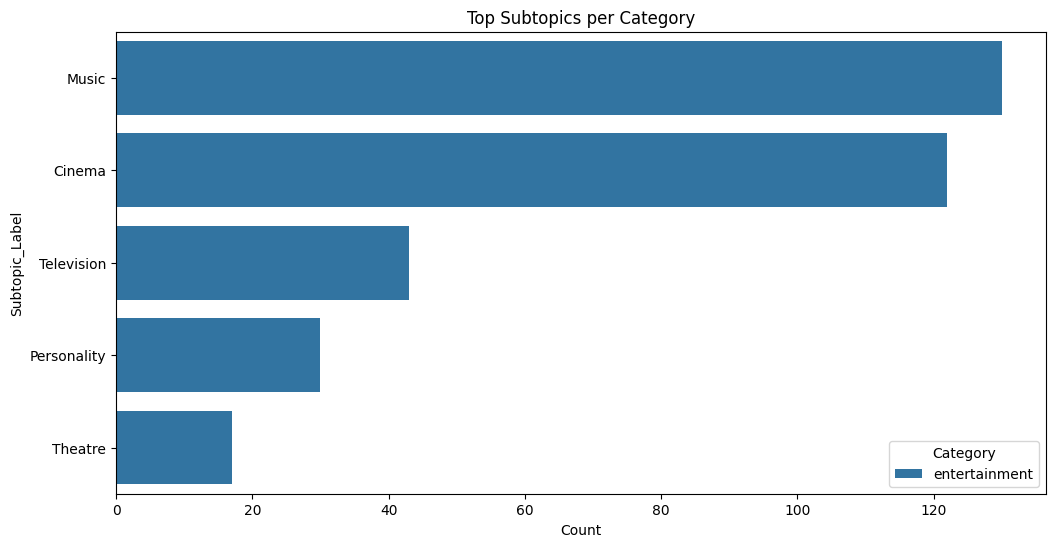

In [ ]:
# Plot top 5 per category
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=top5_per_category,
    x="Count", y="Subtopic_Label", hue="Category"
)
plt.title("Top Subtopics per Category")
plt.show()


We can regex clean those:

In [57]:
import re

def clean_label(label):
    if not isinstance(label, str):
        return label
    # If GPT returned JSON-like text, extract inside
    match = re.search(r'"label"\s*:\s*"([^"]+)"', label)
    if match:
        return match.group(1)
    return label.strip()

df_subtopics["Subtopic_Label"] = df_subtopics["Subtopic_Label"].apply(clean_label)

Rerunning the summary

In [58]:
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

top5_per_category = summary.groupby("Category").head(5)
print(top5_per_category)


        Category Subtopic_Label  Count
4  entertainment          Music    130
1  entertainment         Cinema    122
8  entertainment     Television     43
6  entertainment    Personality     30
9  entertainment        Theatre     17


save the full results into a DataFrame and export to CSV for further analysis or visualization.

In [59]:
import pandas as pd

# Ensure df_subtopics already has:
# Category, Subcluster, Subtopic_Label, Clean_Text

# Save the full detailed dataset
df_subtopics.to_csv("bbc_entertainment_subtopics_full.csv", index=False)

# Also save the summarized counts per category/subtopic
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)
summary.to_csv("bbc_entertainment_subtopics_summary.csv", index=False)

print("✅ Files saved:")
print(" - bbc_subtopics_full.csv  (all rows with labels)")
print(" - bbc_subtopics_summary.csv  (aggregated counts)")


✅ Files saved:
 - bbc_subtopics_full.csv  (all rows with labels)
 - bbc_subtopics_summary.csv  (aggregated counts)
